In [176]:
import tensorflow as tf 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
# Model improvement and Evaluation 
from sklearn import metrics 
from sklearn.metrics import confusion_matrix

print('tensorflow version', tf.__version__)
bank_data = pd.read_csv('data/1_american_dataset.csv')

# data_features = pd.read_csv('data/bankrupt_features.csv')
# data_status = pd.read_csv('data/status_bankrupt.csv')

tensorflow version 2.11.0


In [177]:
bank_data['status'].value_counts()

0    73462
1     5220
Name: status, dtype: int64

In [178]:
neg, pos = np.bincount(bank_data['status'])
total = neg + pos
print('Sample distributions:\n    Total: {}\n    Not Bankrupt (0): {} ({:.2f}% of total)\n    Bankrupt (1): {} ({:.2f}% of total)'.format(
    total, neg, (100 * neg) / total, pos, (100 * pos) / total))

Sample distributions:
    Total: 78682
    Not Bankrupt (0): 73462 (93.37% of total)
    Bankrupt (1): 5220 (6.63% of total)


## Remove entries from the majority class to balance the data.

In [179]:
indices = bank_data[bank_data['status'] == 0].index
random_indices = np.random.choice(indices, size=neg-pos, replace=False)
bank_balanced = bank_data.drop(random_indices)

counts = bank_balanced['status'].value_counts()
print(counts)

0    5220
1    5220
Name: status, dtype: int64


In [180]:
from sklearn.model_selection import train_test_split

numerical_only = bank_balanced.select_dtypes(include=['float64','int64'])
X = numerical_only.drop(['cik', 'fyear', 'status'], axis=1)
y = numerical_only['status']

In [44]:
# normalizer = tf.keras.layers.Normalization(axis=-1)
# normalizer.adapt(X)
# normalizer(X)

<tf.Tensor: shape=(10440, 18), dtype=float32, numpy=
array([[-0.08831016, -0.16695756, -0.11717075, ..., -0.1743905 ,
        -0.14181583, -0.12867276],
       [ 0.19978449, -0.07981596, -0.08360624, ..., -0.07065127,
        -0.06860308, -0.05863809],
       [-0.24646477, -0.2420315 , -0.20716344, ..., -0.23623824,
        -0.21981664, -0.21342848],
       ...,
       [-0.1337317 , -0.2032262 , -0.15729237, ..., -0.21909295,
        -0.17382284, -0.16006272],
       [-0.22250304, -0.23418091, -0.14126202, ..., -0.22863969,
        -0.17805517, -0.14649975],
       [-0.21541864, -0.06312932, -0.19676632, ..., -0.12302953,
        -0.20113291, -0.20217147]], dtype=float32)>

In [181]:
# split data into training (60%), validation (20%), and testing (20%) sets 
X_, X_test, y_, y_test = train_test_split(X, y, train_size=0.8, test_size=0.15, random_state=42, shuffle=True)
X_train, X_validate, y_train, y_validate = train_test_split(X_, y_, train_size=0.82, test_size=0.18, random_state=42, shuffle=True)

In [182]:
print("y_train data distribution:\n", y_train.value_counts())
print("y_validate data distribution:\n", y_validate.value_counts())
print("y_test data distribution:\n", y_validate.value_counts())

input_shape = (X.shape[1],)

y_train data distribution:
 0    3432
1    3416
Name: status, dtype: int64
y_validate data distribution:
 1    753
0    751
Name: status, dtype: int64
y_test data distribution:
 1    753
0    751
Name: status, dtype: int64


In [203]:
def bankruptcy_model():
    model = tf.keras.Sequential([
        # tf.keras.layers.Dense(32, activation='relu', input_shape=input_shape),
        tf.keras.layers.Dense(18, activation='relu', input_shape=input_shape),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(9, activation='relu', input_shape=input_shape),
        # tf.keras.layers.Dense(4, activation='relu', input_shape=input_shape),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])
    
    model.compile(optimizer='adam', 
            loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
            metrics=['accuracy'])
    return model

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=6, monitor='val_loss'),
    # tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    # tf.keras.callbacks.ModelCheckpoint(filepath='./best_model.h5', monitor='val_loss', save_best_only=True)
]

In [204]:
model = bankruptcy_model()
history = model.fit(X_train, y_train,
                    validation_data=(X_validate, y_validate),
                    epochs=100,
                    batch_size=25,
                    # callbacks=callbacks,
                    # class_weight=class_weight
                    )

Epoch 1/100
274/274 [==============================] - 3s 3ms/step - loss: 0.7110 - accuracy: 0.5361 - val_loss: 0.6986 - val_accuracy: 0.5306
Epoch 2/100
274/274 [==============================] - 1s 2ms/step - loss: 0.6616 - accuracy: 0.5822 - val_loss: 0.6887 - val_accuracy: 0.5346
Epoch 3/100
274/274 [==============================] - 1s 2ms/step - loss: 0.6545 - accuracy: 0.6009 - val_loss: 0.6809 - val_accuracy: 0.5592
Epoch 4/100
274/274 [==============================] - 1s 2ms/step - loss: 0.6538 - accuracy: 0.6066 - val_loss: 0.6838 - val_accuracy: 0.5445
Epoch 5/100
274/274 [==============================] - 1s 2ms/step - loss: 0.6501 - accuracy: 0.6133 - val_loss: 0.6825 - val_accuracy: 0.5625
Epoch 6/100
274/274 [==============================] - 1s 2ms/step - loss: 0.6545 - accuracy: 0.6105 - val_loss: 0.6814 - val_accuracy: 0.5705
Epoch 7/100
274/274 [==============================] - 1s 2ms/step - loss: 0.6487 - accuracy: 0.6088 - val_loss: 0.6787 - val_accuracy: 0.5492

In [98]:
def plot_history(history):
    fig, axs = plt.subplots(2, 1, figsize=(12, 8))

    # Plot training & validation accuracy values
    axs[0].plot(history.history['accuracy'])
    axs[0].plot(history.history['val_accuracy'])
    axs[0].set_title('Model accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Training Set', 'Validation Set'], loc='upper left')

    # Plot training & validation loss values
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_title('Model loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Training Set', 'Validation Set'], loc='upper left')

    plt.show()

In [205]:
model.summary()

Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_193 (Dense)           (None, 18)                342       
                                                                 
 batch_normalization_44 (Bat  (None, 18)               72        
 chNormalization)                                                
                                                                 
 dense_194 (Dense)           (None, 9)                 171       
                                                                 
 dense_195 (Dense)           (None, 1)                 10        
                                                                 
Total params: 595
Trainable params: 559
Non-trainable params: 36
_________________________________________________________________


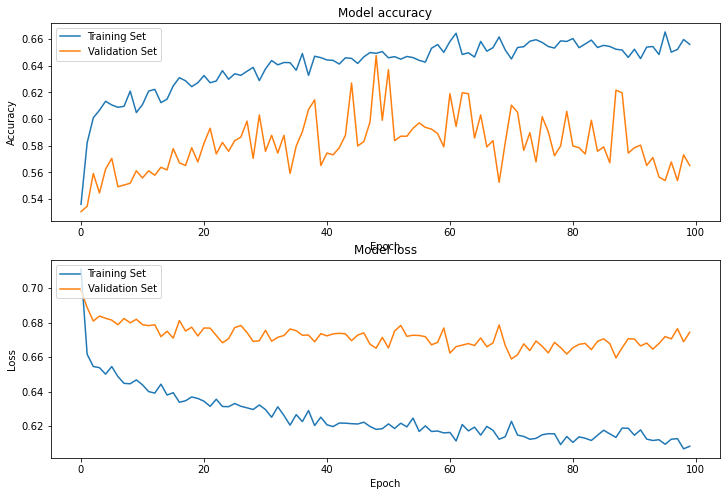

In [206]:
plot_history(history)

In [210]:
y_predict = model.predict(X_test)
print(y_predict)
# Compute confusion matrix
cm = confusion_matrix(y_test, y_predict)
print(cm)

# # Plot confusion matrix
# plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
# plt.colorbar()
# tick_marks = np.arange(2)
# plt.xticks(tick_marks, ['Class 0', 'Class 1'], rotation=45)
# plt.yticks(tick_marks, ['Class 0', 'Class 1'])
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.show()

49/49 [==============================] - 0s 2ms/step
[[0.3821334 ]
 [0.3894311 ]
 [0.47766042]
 ...
 [0.5111874 ]
 [0.54901063]
 [0.5093892 ]]


ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [183]:
def bankruptcy_model_v2(input_shape=(18,)):
    # Define the normalization layer
    # normalization_layer = tf.keras.layers.experimental.preprocessing.Normalization()

    # # Adapt the normalization layer to the data
    # data = tf.ones((1, 18))
    # normalization_layer(data)

    # Define the model
    model = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.Normalization(),
        tf.keras.layers.Dense(18, activation='relu', input_shape=input_shape),
        # tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(9, activation='relu', input_shape=input_shape),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])

    model.compile(optimizer='adam', 
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    return model


In [184]:
model2 = bankruptcy_model_v2()
history2 = model2.fit(X_train, y_train,
                    validation_data=(X_validate, y_validate),
                    epochs=100,
                    batch_size=25,
                    # callbacks=callbacks,
                    # class_weight=class_weight
                    )

Epoch 1/100
274/274 [==============================] - 2s 3ms/step - loss: 92.8703 - accuracy: 0.5539 - val_loss: 34.0720 - val_accuracy: 0.6017
Epoch 2/100
274/274 [==============================] - 1s 2ms/step - loss: 32.8720 - accuracy: 0.5808 - val_loss: 27.0226 - val_accuracy: 0.5977
Epoch 3/100
274/274 [==============================] - 1s 2ms/step - loss: 17.2253 - accuracy: 0.5794 - val_loss: 19.8971 - val_accuracy: 0.5878
Epoch 4/100
274/274 [==============================] - 1s 2ms/step - loss: 15.3358 - accuracy: 0.5663 - val_loss: 13.3838 - val_accuracy: 0.5725
Epoch 5/100
274/274 [==============================] - 1s 2ms/step - loss: 10.3435 - accuracy: 0.5818 - val_loss: 12.4242 - val_accuracy: 0.5864
Epoch 6/100
274/274 [==============================] - 1s 2ms/step - loss: 9.8733 - accuracy: 0.5714 - val_loss: 9.6746 - val_accuracy: 0.5691
Epoch 7/100
274/274 [==============================] - 1s 2ms/step - loss: 6.7847 - accuracy: 0.5767 - val_loss: 8.3860 - val_accura

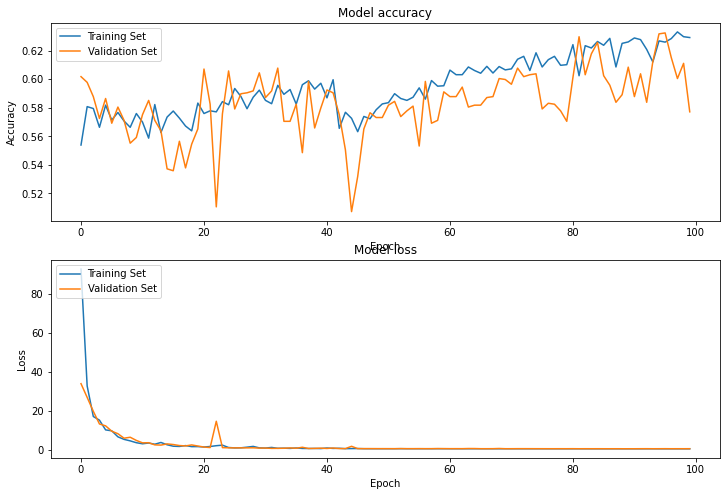

In [185]:
plot_history(history2)

In [143]:
def binary_classification_model(input_shape=(18,)):
    # # Define the normalization layer
    # normalization_layer = tf.keras.layers.experimental.preprocessing.Normalization()

    # # Adapt the normalization layer to the data
    # data = tf.ones((1, 18))
    # normalization_layer(data)
    
    model = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.Normalization(),
        tf.keras.layers.Dense(64, activation='relu', input_shape=input_shape),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [146]:
model3 = binary_classification_model()
history3 = model3.fit(X_train, y_train,
                    validation_data=(X_validate, y_validate),
                    epochs=100,
                    batch_size=36,
                    # callbacks=callbacks,
                    # class_weight=class_weight
                    )

Epoch 1/100
191/191 [==============================] - 4s 5ms/step - loss: 0.7514 - accuracy: 0.5336 - val_loss: 0.7050 - val_accuracy: 0.5572
Epoch 2/100
191/191 [==============================] - 1s 3ms/step - loss: 0.6920 - accuracy: 0.5513 - val_loss: 0.6833 - val_accuracy: 0.5572
Epoch 3/100
191/191 [==============================] - 1s 3ms/step - loss: 0.6863 - accuracy: 0.5629 - val_loss: 0.6795 - val_accuracy: 0.5904
Epoch 4/100
191/191 [==============================] - 1s 4ms/step - loss: 0.6724 - accuracy: 0.5797 - val_loss: 0.6771 - val_accuracy: 0.5512
Epoch 5/100
191/191 [==============================] - 1s 3ms/step - loss: 0.6689 - accuracy: 0.5869 - val_loss: 0.6732 - val_accuracy: 0.5539
Epoch 6/100
191/191 [==============================] - 1s 3ms/step - loss: 0.6643 - accuracy: 0.5787 - val_loss: 0.6740 - val_accuracy: 0.5612
Epoch 7/100
191/191 [==============================] - 1s 3ms/step - loss: 0.6639 - accuracy: 0.5889 - val_loss: 0.6725 - val_accuracy: 0.5745

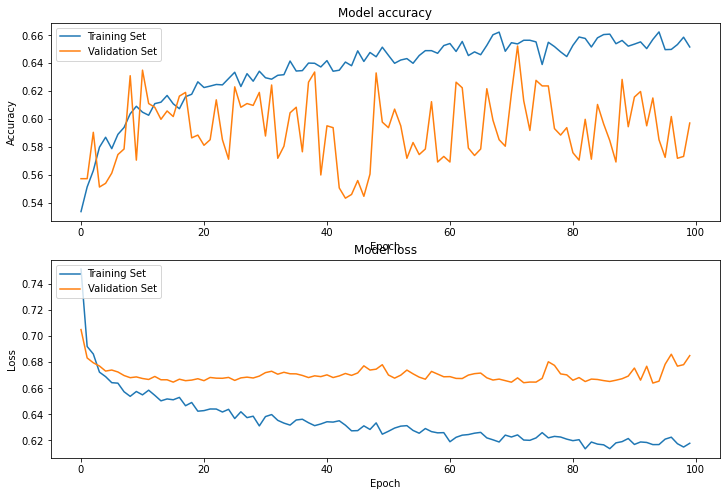

In [160]:
plot_history(history3)

In [192]:
def binary_classification_model_4(input_shape=(18,)):
    # create input layer
    inputs = tf.keras.Input(shape=input_shape)
    
    # create normalization layer
    normalization = tf.keras.layers.experimental.preprocessing.Normalization()
    x = normalization(inputs)
    
    # create hidden layers
    # x = tf.keras.layers.Dense(64, activation='relu')(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.Dense(32, activation='relu')(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(18, activation='relu')(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(9, activation='relu')(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    
    # create output layer
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    # create model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    # compile model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [193]:
model4 = binary_classification_model_4()
history4 = model4.fit(X_train, y_train,
                    validation_data=(X_validate, y_validate),
                    epochs=100,
                    batch_size=24,
                    # callbacks=callbacks,
                    # class_weight=class_weight
                    )

Epoch 1/100
286/286 [==============================] - 2s 3ms/step - loss: 43.3761 - accuracy: 0.5775 - val_loss: 28.8131 - val_accuracy: 0.5731
Epoch 2/100
286/286 [==============================] - 1s 2ms/step - loss: 21.4688 - accuracy: 0.5846 - val_loss: 20.0592 - val_accuracy: 0.6024
Epoch 3/100
286/286 [==============================] - 1s 2ms/step - loss: 14.6889 - accuracy: 0.5940 - val_loss: 22.3457 - val_accuracy: 0.5778
Epoch 4/100
286/286 [==============================] - 1s 2ms/step - loss: 13.2821 - accuracy: 0.5864 - val_loss: 13.7505 - val_accuracy: 0.5711
Epoch 5/100
286/286 [==============================] - 1s 2ms/step - loss: 10.0054 - accuracy: 0.5848 - val_loss: 9.8054 - val_accuracy: 0.5851
Epoch 6/100
286/286 [==============================] - 1s 2ms/step - loss: 9.9214 - accuracy: 0.5846 - val_loss: 13.2528 - val_accuracy: 0.5698
Epoch 7/100
286/286 [==============================] - 1s 2ms/step - loss: 7.2140 - accuracy: 0.5862 - val_loss: 14.3086 - val_accur

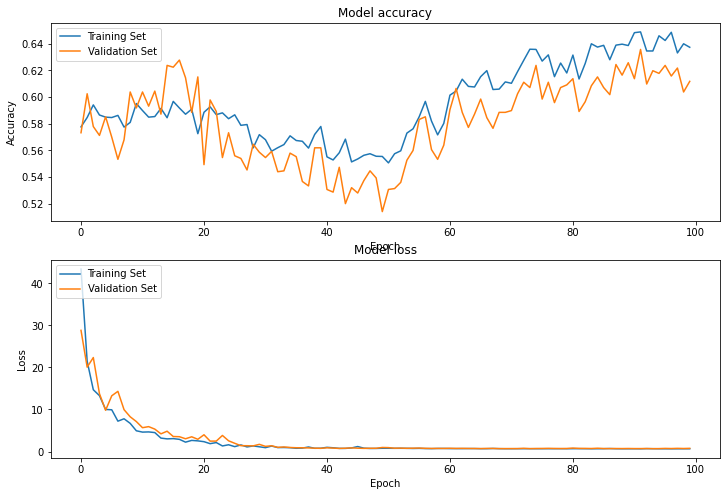

In [194]:
plot_history(history4)